Transformers and Multi-Head Attention

In [2]:
! pip install --quiet "torchmetrics>=0.7, <0.12" "pytorch-lightning>=1.4, <2.0.0" "ipython[notebook]>=8.0.0, <8.12.0" "setuptools==67.4.0" "lightning>=2.0.0rc0" "torchvision" "matplotlib" "torch>=1.8.1, <1.14.0" "seaborn" "matplotlib>=2.2.3, <3.4.0"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.12.3 requires matplotlib>=3.6.0, but you have matplotlib 3.3.4 which is incompatible.


Standard Libraries

In [3]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# Torchvision
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100
from tqdm.notebook import tqdm

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Transformers/")

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will b

Device: cpu


Two pre-trained models are downloaded below. Make sure to have adjusted your CHECKPOINT_PATH before running this code if not already done.

In [4]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file manually,"
                " or contact the author with the full output including the following error:\n",
                e,
            )

a function which computes the output features given the triple of queries, keys, and values:

In [5]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

In [6]:
seq_len, d_k = 3, 2
L.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


# Multi-Head Attention

In [7]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

Transformer Encoder

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """EncoderBlock.

        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim),
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

transformer

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

# Positional encoding

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """Positional Encoding.

        Args:
            d_model: Hidden dimensionality of the input.
            max_len: Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

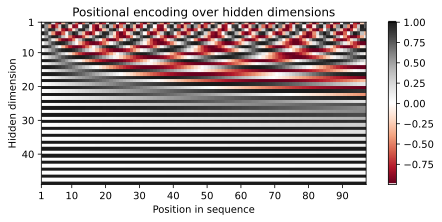

In [12]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will b

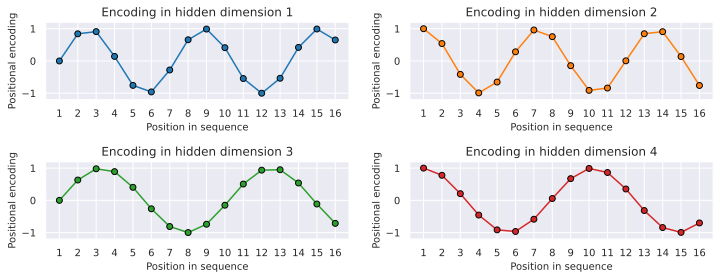

In [13]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12, 4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1, 17), pe[i, :16], color="C%i" % i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Encoding in hidden dimension %i" % (i + 1))
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1, 17))
    ax[i].tick_params(axis="both", which="major", labelsize=10)
    ax[i].tick_params(axis="both", which="minor", labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

Learning rate Warm-up

In [14]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

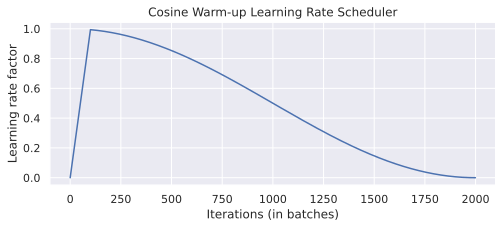

/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.10/_collections_abc.py:999: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will b

In [15]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4, 4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

# PyTorch Lightning Module

Finally, we can embed the Transformer architecture into a PyTorch lightning module. From Tutorial 5, you know that PyTorch Lightning simplifies our training and test code, as well as structures the code nicely in separate functions. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional [CLS] token to the sequence, representing the classifier token. However, here we focus on tasks where we have an output per element.

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions). We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and the smooth cosine decay. The training, validation, and test step is left empty for now and will be filled for our task-specific models.



In [16]:
class TransformerPredictor(L.LightningModule):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        lr,
        warmup,
        max_iters,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """TransformerPredictor.

        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout), nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(
            num_layers=self.hparams.num_layers,
            input_dim=self.hparams.model_dim,
            dim_feedforward=2 * self.hparams.model_dim,
            num_heads=self.hparams.num_heads,
            dropout=self.hparams.dropout,
        )
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        self.lr_scheduler = CosineWarmupScheduler(
            optimizer, warmup=self.hparams.warmup, max_iters=self.hparams.max_iters
        )
        return optimizer

    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.lr_scheduler.step()  # Step per iteration

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

# Sequence to Sequence

In [17]:
class ReverseDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [18]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(dataset(1000), batch_size=128)
test_loader = data.DataLoader(dataset(10000), batch_size=128)

In [19]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


In [20]:
class ReversePredictor(TransformerPredictor):
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [21]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=1,
        max_epochs=10,
        gradient_clip_val=5,
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs * len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

train the model

In [22]:
reverse_model, reverse_result = train_reverse(
    input_dim=train_loader.dataset.num_categories,
    model_dim=32,
    num_heads=1,
    num_classes=train_loader.dataset.num_categories,
    num_layers=1,
    dropout=0.0,
    lr=5e-4,
    warmup=50,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.0.rc0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint saved_models/Transformers/ReverseTask.ckpt`
INFO:lightning.pytorch.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.0.rc0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint saved_models/Transformers

Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

In [23]:
print("Val accuracy:  %4.2f%%" % (100.0 * reverse_result["val_acc"]))
print("Test accuracy: %4.2f%%" % (100.0 * reverse_result["test_acc"]))

Val accuracy:  100.00%
Test accuracy: 100.00%


In [24]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [25]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [26]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin="lower", vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()


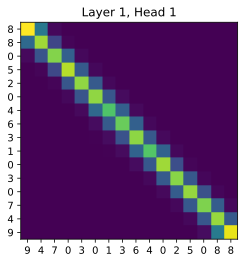

In [27]:
plot_attention_maps(data_input, attention_maps, idx=0)

Set Anomaly Detection

In [28]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1, 3, 1, 1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1, 3, 1, 1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)]
)
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


In [29]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to saved_models/Transformers/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features


train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/391 [00:00<?, ?it/s]